In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import os
import glob
import json
import geopandas as gp
import matplotlib.pyplot as plt


In [3]:
NIS_name = pd.read_csv('../../data/raw/GIS/NIS_name.csv')

In [4]:
NIS_arrondissement = pd.read_csv('../../data/raw/GIS/NIS_arrondissement.csv')

In [5]:
arr_list = []

In [ ]:
for filename in glob.glob('../../data/interim/model_parameters/arrondissements/*.json'):
    name = filename.split('/')[-1].split('_')[0]
    arr_list.append(name)
    print(name)

In [ ]:
NIS_arrondissement[NIS_arrondissement.NIS=='58000']

In [ ]:
NIS_arrondissement.NIS = NIS_arrondissement.NIS.astype(str)

In [ ]:
set(NIS_arrondissement.NIS) - set(arr_list)

In [8]:
samples_path = '../../data/interim/model_parameters/arrondissements/'

In [9]:
sample_dicts = {}

In [10]:
for filename in glob.glob(os.path.join(samples_path+'*.json')):
    arr = filename.split('/')[-1].split('_2020')[0]
    with open(filename, 'r') as fp:
        sample_dicts[arr] = json.load(fp)

In [11]:
R0_dict = {arr:np.mean(sample_dicts[arr]['R0']).round(2) for arr in sample_dicts.keys()}

In [12]:
beta_dict = {arr:np.mean(sample_dicts[arr]['beta']).round(2) for arr in sample_dicts.keys()}

Basis reproductiegetal zegt iets over hoe snel initiële verspreiding was in een arrondissement (of maw hoeveel within-contacts er zijn). Maar om evolutie op te volgen => niet beter effectief reproductiegetal te berekenen?

In [ ]:
## Create arrondissements shapefile
# gemeentes = gp.read_file("../../data/raw/geopandas/BE/AD_2_Municipality.shp")
# gemeentes['short_nis'] = gemeentes.NISCode.apply(lambda x: str(x)[:2])
# # select the columns that you with to use for the dissolve and that will be retained
# gemeentes_new = gemeentes[['short_nis','geometry']]
# # dissolve the state boundary by region 
# arrondissementen = gemeentes_new.dissolve(by='short_nis').reset_index()
# arrondissementen['NIS'] = arrondissementen.short_nis.apply(lambda x: x+'000')
# arrondissementen = arrondissementen[['NIS','geometry']]
# arrondissementen.to_file('../../data/raw/geopandas/BE/Arrondissements.shp')

In [13]:
# Read arrondissements shapefile
arrondissementen = gp.read_file("../../data/raw/geopandas/BE/Arrondissements.shp")
provinces = gp.read_file("../../data/raw/geopandas/BE/AD_4_Province.shp")

In [14]:
R0_df = pd.DataFrame.from_dict(R0_dict, orient='index').reset_index().rename(columns={'index':'NIS',0:'R0'})
R0_df_geom = gp.GeoDataFrame(pd.merge(R0_df, arrondissementen, on='NIS'))

In [15]:
beta_df = pd.DataFrame.from_dict(beta_dict, orient='index').reset_index().rename(columns={'index':'NIS',0:'beta'})
beta_df_geom = gp.GeoDataFrame(pd.merge(beta_df, arrondissementen, on='NIS'))

Text(0.5, 1, 'R0 per arrondissement')

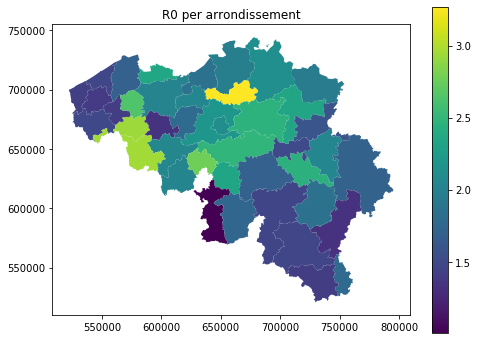

In [16]:
fig,ax = plt.subplots(figsize=(8,6))
R0_df_geom.plot(column='R0', cmap='viridis', ax=ax, legend=True)
ax.set_title('R0 per arrondissement')

Text(0.5, 1, 'beta per arrondissement')

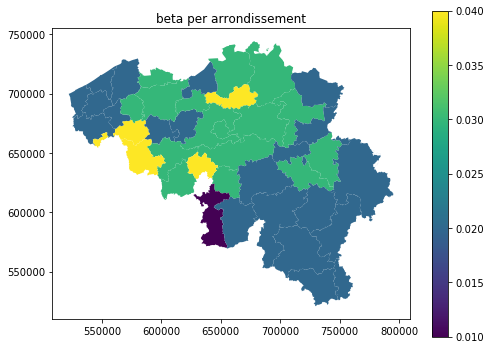

In [17]:
fig,ax = plt.subplots(figsize=(8,6))
beta_df_geom.plot(column='beta', cmap='viridis', ax=ax, legend=True)
ax.set_title('beta per arrondissement')

In [ ]:
fig,ax = plt.subplots(figsize=(8,6))
provinces.plot(ax=ax)